# Transformermodellen for prediksjon av sekvenser

#### OPPGAVE 1

##### Oppgave 1.1

For å trene en transformermodell så trenger vi et datasett som består av flere tupler som inneholder $\mathbf{x}$ og $\mathbf{y}$ vektorer, $ D = \{ (\mathbf{x_0}, \mathbf{y_0}), (\mathbf{x_1}, \mathbf{y_1}), \ldots, (\mathbf{x_{n-1}}, \mathbf{y_{n-1}}) \} $. For å vise et eksempel på en av tuplene i datasettet, $(\mathbf{x_0}, \mathbf{y_0})$, velger vi $r = 2$, $a = 43$, $b = 7$, $c = 18$ og $d = a \cdot b + c = 319$. Vektoren $\mathbf{x_0}$ er bygget opp slik at vi får de $r$ første sifferene av $a$, $b$, $c$ og $d$ og lengden til $\mathbf{x_i}$ blir dermed $4 \cdot r$. I dette tilfellet får vi da $\mathbf{x_0} = [4, 3, 0, 7, 1, 8, 3, 1]$. $\mathbf{y_0}$ består av alle sifferene til $d$ og blir her $\mathbf{y_0} = [3, 1, 9]$.  

##### Oppgave 1.2


Vi skal  nå anta at optimeringen er ferdig og at vi har funnet parameterene ${\theta}$ som minimerer objektfunksjonen $\mathcal{L}$, vi skal dermed bruke modellen $f_{\theta}$ til å predikere $d$ gitt $a, b$ og $c$. Modellen $f_{\theta}$ skal testes på en sekvens som bare inneholder sifferene til $a, b,$ og $c$ og vi befinner oss i testfasen. I testfasen skal $\mathbf{x}^{(0)}\in \mathbb{Z^{3r}}$, ved å kjøres gjennom modellen, få ut $f_{\theta}(\mathbf{x}) = \mathbf{z}^{0}$ der $\mathbf{z}\in \mathbb{Z^{3r}}$, altså en sekvens av samme dimensjon.

Vi velger fortsatt $r = 2$, $a = 43$, $b = 7$ og $c = 18$ og skal predikere $d$. For å predikere $d\in \mathbb{Z^{r+1}}$ skal hver evaluering av modellen predikere neste siffer i sekvensen og legge det til bakerst i $\mathbf{x}$. Dette blir input i neste prediksjon helt til det er predikert $r+1$ nye heltall som ideelt sett skal være lik $d$. 


Vi ønsker å finne ${\theta}$ slik at $\hat{\mathbf{y}} = [\hat{z_5}, \hat{z_6}, \hat{z_7}] = [3, 1, 9]= \mathbf{y}$


Vi starter med første sekvens, $\mathbf{x}^{(0)} = [4,3,0,7,1,8]$, og setter inn i modellen $f_{\theta}([4,3,0,7,1,8]) = [\hat{z_0}^{(0)}, \hat{z_1}^{(0)},..., \hat{z_5}^{(0)}]$ 

Legger til bakerste siffer fra outputen inn i neste sekvens: $\mathbf{x}^{(1)} = [4,3,0,7,1,8, \hat{z_5}^{(0)}]$. Predikerer neste sekvens: $f_{\theta}([4,3,0,7,1,8, \hat{z_5}^{(0)}]) = [\hat{z_0}^{(1)}, \hat{z_1}^{(1)},..., \hat{z_6}^{(1)}]$ 

Gjentar prosessen: $\mathbf{x}^{(2)} = [4,3,0,7,1,8, \hat{z_5}^{(0)}, \hat{z_6}^{(1)}]$, $f_{\theta}([4,3,0,7,1,8, \hat{z_5}^{(0)}, \hat{z_6}^{(1)}] = [\hat{z_0}^{(2)}, \hat{z_1}^{(2)},..., \hat{z_7}^{(2)}]$

Etter $3$ evalueringer av modellen ender vi opp med sekvensen: $\mathbf{x}^{(3)} = [4,3,0,7,1,8, \hat{z_5}^{(0)}, \hat{z_6}^{(1)}, \hat{z_7}^{(2)}]$

Det er nå predikert $r + 1 = 3$ nye heltall, $\hat{\mathbf{y}} = [\hat{z_5}^{(0)}, \hat{z_6}^{(1)}, \hat{z_7}^{(2)}]$. Nå kan vi sammenligne den predikerte $\hat{\mathbf{y}}$ med vår $\mathbf{y} = [3, 1, 9]$. 

Dersom modellen har gjennomgått en god trening skal $\mathbf{z} = \hat{\mathbf{y}} = \mathbf{y} = [3,1,9]$.

##### Oppgave 1.3

Vi bruker cross-entropy som objektfunksjon, og setter $m = 5$ og $\mathbf{y} = [4, 3, 2, 1]$.

Dersom cross-entropy funksjonen $\mathcal{L}({\theta},D) = 0$ betyr det at modellen gir en riktig prediksjon. I et tilfelle der $\hat{Y} = F_{\theta}(x) = onehot(\mathbf{y})$ vil vi få $\mathcal{L}({\theta},D) = 0$. Dette betyr også at $\hat{\mathbf{y}} = argmax_{col}(\hat{Y})$

Matematisk sett vil vi få: 

$\hat{Y} = onehot(\mathbf{y}) = onehot([4, 3, 2, 1]) := \begin{bmatrix} 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ 1 & 0 & 0 & 0 \\\end{bmatrix}$


Fordelingen til $\hat{Y}$ tilsvarer en kollonnevis onehot sannsynlighetsfordeling, der summen av hver kolonne er $1$. For hver kolonne, $i$, vil ideksen av sifferet $1$ representere verdien til tilsvarende siffer, i  $\mathbf{y_{i}}$. Resten av matrisen $\hat{Y}$ må derfor bestå av nullere.

Slik finner vi videre $\hat{y}$ ved en kolonnevis $argmax$ operasjon:

$\hat{\mathbf{y}} = argmax_{col}(\hat{Y}) = argmax_{col}\begin{bmatrix} 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ 1 & 0 & 0 & 0 \\\end{bmatrix} = [4,3,2,1]$

Som forventet blir $\mathbf{\hat{y}}$ blir lik $\mathbf{y}$, som alltid vil stemme for denne type fordeling.

##### Oppgave 1.4
Gitt:
$\theta = \{ W_E, W_P, W_U, \{W_O^{(l)}, W_V^{(l)}, W_Q^{(l)}, W_K^{(l)}, W_1^{(l)}, W_2^{(l)}\} _{l=0}^{L-1}\}$

For å kunne bestemme totalt antall enkeltparamtere til transformermodellen, må vi se på dimensjonene til de forskjellige vektmatrisene.
Dimensjonen til $W_E$ og $W_U$ er $d \times m$, dimensjonen til $W_P$ er $d \times n_{max}$ , dimensjonen til ${W_O}^{(l)}, {W_V}^{(l)}, {W_Q}^{(l)}$ og ${W_K}^{(l)}$ er $k \times d$ og dimensjonen til ${W_1}^{(l)}$ og ${W_2}^{(l)}$ er $p \times d$. 

Vi får da totalt $w = 2dm + dn_{max} + (4kd + 2pd) \cdot L$ enkeltparametere som vi kan optimere.

##### Oppgave 1.5

Tranformermodellen er beskrevet i likning (4)-(9). Vi skal ta utgangspunkt i disse parameterene:

$n = n_{max} = 1$, $m = d = k = p = 2$, $L = 1 \rightarrow l = 0,..., L-1 = 0$ 

$W_{O} = W_{V} = W_{Q} = W_{K} = W_{1} = W_{2} = W_{u} = I_{2x2} = \begin{bmatrix} 1 & 0 \\ 0 & 1\\\end{bmatrix} $

$\sigma(x) = \text{Relu}(x) = \max(0, x)$

$ W_{E} = \begin{bmatrix} 1 & 0 \\ 0 & \alpha \end{bmatrix}$, $ W_{p} = \begin{bmatrix} 1 \\ 0\\\end{bmatrix}$

$D\in{\mathbb{R}^{n\times n}}$ er null på øvre triangulær inkludert diagonalen, slik at $n = 1$ gir $D = [0]$.

Videre vil vi vise at vi må ha $\alpha > 1$ for å få $\hat{z} = [1]$ som output når input er $x = [1]$.

Vi begynner med likning $(4)$ $X = onehot(\mathbf{x})$. Her tar vi inn en vektor $\mathbf{x}\in{\mathbb{Z}^{1}}$ og får ut en matrise $X$.

\begin{equation} 
X = \text{onehot}([1]) = \begin{bmatrix} 0 \\ 1 \end{bmatrix}, \quad X \in \mathbb{Z}^{2\times1} \tag{4}
\end{equation}


I likning $(5)$  $z_{0} = W_{E}X + [W_{p}]_{0:n}$ tar vi inn matrisen $X$ fra likning $(4)$ og får ut en matrise $z_{0}$.

\begin{equation} 
z_{0} = \begin{bmatrix} 1 & 0 \\ 0 & \alpha \\\end{bmatrix} \cdot \begin{bmatrix} 0 \\ 1\\\end{bmatrix} + \begin{bmatrix} 1 \\ 0\\\end{bmatrix} = \begin{bmatrix} 0 \\ \alpha\\\end{bmatrix} + \begin{bmatrix} 0 \\ 1\\\end{bmatrix} = \begin{bmatrix} 1 \\ \alpha\\\end{bmatrix}, \quad z_{0}\in{\mathbb{R}^{2 \times 1}} \tag{5}
\end{equation}

I likning $(6)$  $z_{\frac{1}{2}} = f_{0}^{A}(z_{0}) = z_{0} + W_{0}^{T} W_{V} z_{0} A(z_{0})$ får vi ut en matrise $z_{\frac{1}{2}}$.

For å finne denne må vi første finne $softmax_{col}$ av $z_{0}$. Det gjør vi i likning $(3)$ $A(z_{0}) = softmax_{col}(z_{0}^{T} W_{Q}^{T} W_{k} z_{0} + D)$.

\begin{equation}
A(\begin{bmatrix} 1 \\ \alpha \\\end{bmatrix}) = softmax_{col}(\begin{bmatrix} 1 & \alpha \\\end{bmatrix} \begin{bmatrix} 1 & 0 \\ 0 & 1 \\\end{bmatrix} \begin{bmatrix} 1 & 0 \\ 0 & 1 \\\end{bmatrix} \begin{bmatrix} 1 \\ \alpha\\\end{bmatrix} + [0]) = softmax_{col}(\begin{bmatrix} 1 & \alpha \\\end{bmatrix} \begin{bmatrix} 1 \\ \alpha \\\end{bmatrix} + [0]) = softmax_{col}([\alpha^{2} + 1]) = \frac{\exp^{1 + \alpha^2}}{\exp^{1 + \alpha^2}} = 1 \tag{3}
\end{equation}

Bruker så dette i likning (6):

\begin{equation}
z_{\frac{1}{2}} = f_{0}^{A}(z_{0}) = \begin{bmatrix} 1 \\ \alpha \\ \end{bmatrix} + \begin{bmatrix} 1&0\\0&1\\\end{bmatrix} \begin{bmatrix} 1&0\\0&1\\\end{bmatrix} \begin{bmatrix} 1 \\ \alpha \\ \end{bmatrix} A(\begin{bmatrix} 1 \\ \alpha \\ \end{bmatrix}) = \begin{bmatrix} 1 \\ \alpha \\ \end{bmatrix} + \begin{bmatrix} 1 \\ \alpha \\ \end{bmatrix} = \begin{bmatrix} 2 \\ 2 \alpha \\ \end{bmatrix},\quad z_{\frac{1}{2}}\in{\mathbb{R}^{2 \times 1}} \tag{6}
\end{equation}


I likning $(7)$  $z_{1} = f_{0}^{F}(z_{\frac{1}{2}}) = z_{\frac{1}{2}} + W_{2}^{T} \sigma(W_{1}z_{\frac{1}{2}})$ skal vi få ut en matrise $z_{1}$.

\begin{equation}
z_{1} = f_{0}^{F}(z_{\frac{1}{2}}) = \begin{bmatrix} 2 \\ 2 \alpha \\\end{bmatrix} + \begin{bmatrix} 1&0\\0&1\\\end{bmatrix} \sigma (\begin{bmatrix}2\\2\alpha\\\end{bmatrix}) = \begin{bmatrix}2\\2\alpha\\\end{bmatrix} + max(0,\begin{bmatrix}2\\2\alpha\\\end{bmatrix}), \quad z_{1}\in{\mathbb{R}^{2\times1}} \tag{7}
\end{equation}

Her får vi to utfall:

\begin{equation}
For\, \alpha > 0:\, \begin{bmatrix}2\\2\alpha\\\end{bmatrix} + max(0,\begin{bmatrix}2\\2\alpha\\\end{bmatrix}) = \begin{bmatrix}2\\2\alpha\\\end{bmatrix} + \begin{bmatrix}2\\2\alpha\\\end{bmatrix} = \begin{bmatrix}4\\4\alpha\\\end{bmatrix},\quad z_{1}\in{\mathbb{R}^{2\times1}} \tag{7.1}
\end{equation}

\begin{equation}
For\, \alpha < 0:\,\begin{bmatrix}2\\2\alpha\\\end{bmatrix} + max(0,\begin{bmatrix}2\\2\alpha\\\end{bmatrix}) = \begin{bmatrix}2\\2\alpha\\\end{bmatrix} + \begin{bmatrix}2\\0\\\end{bmatrix} = \begin{bmatrix}4\\2\alpha\\\end{bmatrix},\quad z_{1}\in{\mathbb{R}^{2\times1}} \tag{7.2}
\end{equation}


I likning $(8)$  $Z = softmax_{col}(W_{U}^{T}z_{L})$ får vi ut en matrise.

\begin{equation}
For \, \alpha > 0: softmax_{col}(\begin{bmatrix}4\\4\alpha\\\end{bmatrix}) = \begin{bmatrix}  \frac{e^{4}}{e^{4} + e^{4\alpha}} \\  \frac{e^{4\alpha}}{e^{4} + e^{4\alpha}} \\\end{bmatrix}, \quad Z\in{\mathbb{R}^{2\times1}} \tag{8.1}
\end{equation}

\begin{equation}
For \, \alpha < 0: softmax_{col}(\begin{bmatrix}4\\2\alpha\\\end{bmatrix}) = \begin{bmatrix} \frac{e^{4}}{e^{4} + e^{2\alpha}} \\ \frac{e^{2\alpha}}{e^{4} + e^{2\alpha}} \\\end{bmatrix}, \quad Z\in{\mathbb{R}^{2\times1}} \tag{8.2}
\end{equation}


I likning $(9)$ $\hat{z} = argmax_{col}(Z)$ får vi ut et matrise.

\begin{equation}
For \, \alpha > 0: argmax_{col}(\begin{bmatrix}  \frac{e^{4}}{e^{4} + e^{4\alpha}} \\  \frac{e^{4\alpha}}{e^{4} + e^{4\alpha}} \\\end{bmatrix}), \quad \hat{z}\in\mathbb{Z}^{1} \tag{9.1}
\end{equation}

\begin{equation}
For \, \alpha < 0: argmax_{col}(\begin{bmatrix}  \frac{e^{4}}{e^{4} + e^{2\alpha}} \\  \frac{e^{2\alpha}}{e^{4} + e^{2\alpha}} \\\end{bmatrix}), \quad \hat{z}\in\mathbb{Z}^{1} \tag{9.2}
\end{equation}

For at $\hat{z} = 1$ må vi ha at det nederste elementet i vektoren være størst, altså:

I likning $(8.1)$ får vi dermed $\frac{e^{4\alpha}}{e^{4} + e^{4\alpha}} > \frac{e^{4}}{e^{4} + e^{4\alpha}}$ $\rightarrow$ $\alpha > 1$

Tilsvarende for likning $(8.2):$ $\frac{e^{2\alpha}}{e^{4} + e^{2\alpha}} > \frac{e^{4}}{e^{4} + e^{2\alpha}}$ $\rightarrow$ $\alpha > 2$

I likning $(8.2)$ får vi både $\alpha < 0$, $\alpha > 2$, og dette gir $L = \emptyset$.

Vi har dermed eneste gyldige løsning $\alpha > 1$ for at $\hat{z} = [1]. \quad \blacksquare$

#### OPPGAVE 2

##### Oppgave 2.1
Transformermodellen vår består av et nevralt nettverk, som er implementert i neural_network.py. Vi har brukt objektorientert programmering for å implementere alle lagene som bygger opp nettverket. Baseklassen Layer inneholder forward(), backward() og step_gd() som er funksjonene til lagene. I Neural_network settes alle lagene sammen og det kjøres forward pass, backward pass og gradient descent på alle lagene. 

Grunnen til at vi bruker objektorientert programmering er at lagene skal kunne arve fra hverandre. I tillegg vil dette gi en ryddig og strukturert kode. Klassen Layer er baseklassen, med flere underklasser. Alle underklassene arver funksjonene fra Layer, underklassene overskriver forward() og backward() funksjonene fra Layer slik at de er tilpasset det spesifikke laget. step_gd() er en optimeringsalgoritme og denne vil arves av resten av lagene. Det er kun de lagene med parametere, altså lag som ikke inneholder underlag, som beholder step_gd() som definert i Layer. Resten av lagene overskriver step_gd() slik at den kan utføre gradient descent på hvert av underlagene.

Vårt nevrale nettverk er bygget opp av lagene EmbedPosition, TransformerBlock, LinearLayer og Softmax, som igjen er bygget opp av flere underliggende lag. NeuralNetwork bruker arv når den utfører gradient descent på lagene ved at de enten arver fra et av de overliggende lagene, eller overskriver step_gd().

##### Oppgave 2.2

I vår implementering av transformermodellen har vi valgt å endre på deler av den gitte koden. Dette har vi gjort for at vi skal kunne kompilere med Numba som vil gjøre at koden vår kjører raskere. Prosjektet består av forholdsvis store beregninger og derfor ønsket vi å minimere kjøretiden ved hjelp av njit (Numba, *Performance tips*) og jitclass (Numba, *Compiling Python classes with @jitclass*). Vi tar også i bruk 'parallel=True', noe som gjør at Numba vil kompilere en versjon som kjører kode parallelt der den kan. Vi har altså ikke endret hva den gitte koden gjør, bare gjort den raskere. Dette har medført at vi har laget egne funksjoner som kan kopileres, i stedet for å bruke innebygde funksjoner et par steder.

Videre har vi valgt å dele opp lagene noe annerledes enn utdelt kode. En av endringene vi har valgt å gjøre er at vi har laget en ny klasse Transformerblock, da vi synes dette ble mer oversiktlig. Denne er en sammensetning av underlagene SelfAttention og FeedForward. Laget SelfAttention er det som i prosjektbeskrivelsen blir referert til som Attention, og vi har kalt underlaget til SelfAttention for Attention slik som i (Vaswani et al., 2017).

I tillegg har vi lagt til bias som en ekstra parameter i den nøstede dictionaryen, som er en viktig del av et nevralt nettverk. Bias er en konstant som legges til for å helle aktiveringsfunksjonen mot positiv eller negativ side ('What Is the Necessity of Bias in Neural Networks?').

##### Oppgave 2.3
Adam er en optimeringsalgoritme som er mer effektiv enn gradient descent. Vi implementerer klassen Optimizer som gjør koden vår mer generell, slik at det er mulig å lage flere optimeringsalgoritmer som kan brukes i nettverket. Adam implementeres som en barneklasse av Optimizer. Vi har endret step_gd() i klassen Layer til å ta inn en parameter av klassen Optimizer.

#### OPPGAVE 3

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
%config InlineBackend.figure_formats = ['svg'] # Makes the plots svg (visually better)
import numpy as np
import matplotlib.pyplot as plt
from layers import CrossEntropy
from optimizer import Adam
from data_generators import get_train_test_sorting, get_train_test_addition
from layers import *
from utils import *
from testing import *
from training import *

##### Oppgave 3.1 - Testing av koden

For å teste koden har vi brukt deler av den utleverte notebooken test_implementation.ipynb. Vi har også implimentert noen egne tester. 

In [7]:
# We choose some arbitrary values for the dimensions
b = 6
n_max = 7
m = 8
n = 5

d = 10
k = 5
p = 20

# Create an arbitrary dataset
x = np.random.randint(0, m, (b,n))
y = np.random.randint(0, m, (b,n_max))

# initialize the layers
feed_forward = FeedForward(d,p)
self_attention = SelfAttention(d,k)
embed_pos = EmbedPosition(n_max,m,d)
un_embed = LinearLayer(d,m, True)
softmax = Softmax()
transformerblock = TransformerBlock(d,k,p)

# a manual forward pass
X = jit_onehot(x, m)  # (b, m, n)
z0 = embed_pos.forward(X)
z1 = feed_forward.forward(z0)
z2 = self_attention.forward(z1)
z3 = un_embed.forward(z2)
Z = softmax.forward(z3) 

# Check the shapes
assert X.shape == (b,m,n), f'X.shape={X.shape}, expected {(b,m,n)}'
assert z0.shape == (b,d,n), f'z0.shape={z0.shape}, expected {(b,d,n)}'
assert z1.shape == (b,d,n), f'z1.shape={z1.shape}, expected {(b,d,n)}'
assert z2.shape == (b,d,n), f'z2.shape={z2.shape}, expected {(b,d,n)}'
assert z3.shape == (b,m,n), f'z3.shape={z3.shape}, expected {(b,m,n)}'
assert Z.shape == (b,m,n), f'Z.shape={Z.shape}, expected {(b,m,n)}'

#is X one-hot?
assert X.sum() == b*n, f'X.sum()={X.sum()}, expected {b*n}'
assert np.allclose(Z.sum(axis=1), 1), f'Z.sum(axis=1)={Z.sum(axis=1)}, expected {np.ones(b)}'
assert np.abs(Z.sum() - b*n) < 1e-5, f'Z.sum()={Z.sum()}, expected {b*n}'
assert np.all(Z>=0), f'Z={Z}, expected all entries to be non-negative'

<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))


Vi ser at det ikke printes noe for testene over, dimensjonene er derfor riktig. 

Under implementerer vi funksjoner for å teste at backward pass og adam fungerer som de skal. 

In [8]:

def get_test_data():
   '''
   Generating at training set.

   '''
   data_set = get_train_test_sorting(length=5, num_ints=2, samples_per_batch=250, n_batches_train=10, n_batches_test=2)
   train_set = list(zip(data_set['x_train'], data_set['y_train']))
   return train_set


def test_backward():
   '''
   Testing if bacward pass works.

   '''
   model = make_model()
   grad_loss = np.random.randn(250)
   train_set = get_test_data()

   # Taking onehot so it fits into our model
   batch_x = jit_onehot(train_set[0][0], 2)
   Y_pred = model.forward(batch_x)

   # Setting the loss function to cross entropy
   loss_function = CrossEntropy()
   y_true = train_set[1][0]

   # Taking one hot of y_true so it can compare with Y_pred in our loss function
   Y_true = jit_onehot(y_true, 2)
   loss_function.forward(Y_pred, Y_true)

   # Getting the gradient from cross entropy's bacward pass
   grad_loss = loss_function.backward()
   model.backward(grad_loss)
  

def test_adam():
   '''
   Testing if adam works.

   '''
   np.seterr(all='raise')

   # Initialize model and optimizer
   model = make_model()
   optimizer = Adam()
   # Overfit on a single example

   # Get all training data
   train_set = get_test_data()

   loss_function = CrossEntropy()

   m = 2

   # First input value from training set
   input = train_set[0][0]
   output = train_set[0][1]
   batch_x = jit_onehot(input, m)


   for _ in range(1000):
      Y_hat = model.forward(batch_x)
      # y_hat: (b, m, n)
      y_hat = np.argmax(Y_hat, axis=1)[:,-5:]
      y_true = train_set[1][0]
      Y_true = jit_onehot(y_true, m)
      
      correct = y_hat == output
      accuracy = np.mean(correct)

      loss_value = loss_function.forward(Y_hat, Y_true).mean()

      # dLdY: (b, m, n)
      grad_loss = loss_function.backward()
      model.backward(grad_loss)
      model.step_gd(optimizer)

      # print(f'{accuracy=:.5f}, {loss_value=:.5f}')
   
      # Checks if loss is non-negative
      assert loss_value >= 0, f'L={loss_value}, expected L>=0'
      assert grad_loss.shape == Y_hat.shape, f'grad_Z.shape={grad_loss.shape}, expected {Y_hat.shape}'

      # Checks if loss is zero when prediction is perfect
      ideal_loss_value = loss_function.forward(Y_true, Y_true).mean()
      assert ideal_loss_value < 1e-5, f'L={ideal_loss_value}, expected L<1e-5'


if __name__ == '__main__':
   test_backward()
   test_adam()

#### Oppgave 3.2
Vi har implenentert en treningsfunksjon for sortering og addisjon i training.py. Vi følger med på gjennomsnittslosset per batch underveis ved hjelp av progressbarsene våres, slik at vi tydlig kan se at det går ned. Etterpå plotter vi disse i oppgave 3.3 og 3.4.

##### Oppgave 3.3 - Sorteringsproblemet

Training model: 100%|██████████| 300/300 [00:29<00:00, 10.25it/s, loss=0.000895, accuracy=1]  


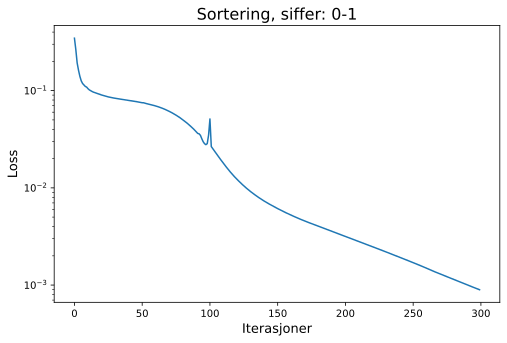

In [84]:
n = 300
test_model_1 = make_model(r=5, d=10, m=2, L=2, p=15, k=5)

sorting_data1 = get_train_test_sorting(5, 2, 250, 10, 10)
trained_model1, mean_loss_arr1 = training_sorting(test_model_1, CrossEntropy(), Adam(0.01), sorting_data1, 2, n_epochs=n)

iter = np.arange(n)

plt.figure(figsize=(8, 5))
plt.title('Sortering, siffer: 0-1', fontsize = 16)
plt.xlabel('Iterasjoner', fontsize = 13)
plt.ylabel('Loss', fontsize = 13)
plt.semilogy(iter, mean_loss_arr1)
plt.show()

In [85]:
accuracy1 = test_sorting(trained_model1, sorting_data1, m=2, r=5)
print(f'Prosentandel riktige for sortering (siffer: 0-1): {np.round(accuracy1, 1)}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Prosentandel riktige for sortering (siffer: 0-1): 100.0%


For sortering av siffer 0-1, får vi veldig lavt loss i treningen. På testingen får vi høy proesentandel treff, som viser at transformermodellen og treningen fungerer bra.

Training model: 100%|██████████| 250/250 [01:45<00:00,  2.37it/s, loss=0.389, accuracy=0.689]


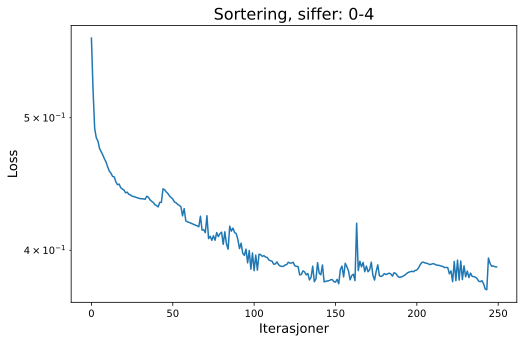

In [167]:
n = 250
test_model_2 = make_model(r=7, d=20, m=5, L=2+1, p=25, k=10)

sorting_data2 = get_train_test_sorting(7, 5, 250, 20, 20)
trained_model2, mean_loss_arr2 = training_sorting(test_model_2, CrossEntropy(), Adam(0.005), sorting_data2, 5, n_epochs=n)

iter = np.arange(n)

plt.figure(figsize=(8, 5))
plt.title('Sortering, siffer: 0-4', fontsize = 16)
plt.xlabel('Iterasjoner', fontsize = 13)
plt.ylabel('Loss', fontsize = 13)
plt.semilogy(iter, mean_loss_arr2)
plt.show()

In [209]:
accuracy2 = test_sorting(trained_model2, sorting_data2, m=5, r=7)
print(f'Prosentandel riktige for sortering (siffer: 0-4): {np.round(accuracy2, 1)}%')

  0%|          | 0/20 [00:00<?, ?it/s]

Prosentandel riktige for sortering (siffer: 0-4): 68.0%


Ved sortering av siffer 0-4 ser vi at losset ikke blir like lavt som ved siffer 0-1. Dette er som forventet da det er et vanskeligere problem. 

Vi prøvde å justere på nettverket vårt, og fant ut at vi fikk best resultat med L=3. I tillegg har vi endret på læringsraten alpha i Adamsteget, og fant ut at 0.001 fungerte best. Selv om dette ikke er like bra som forrige problem, ser vi at vi får en stor prosentandel treff, som vil si at treningen vår fungerer bra. 


##### Oppgave 3.4 - Addisjonsproblemet

Training model:   0%|          | 0/200 [00:00<?, ?it/s]

Training model: 100%|██████████| 200/200 [01:18<00:00,  2.54it/s, loss=0.861, accuracy=0.296]


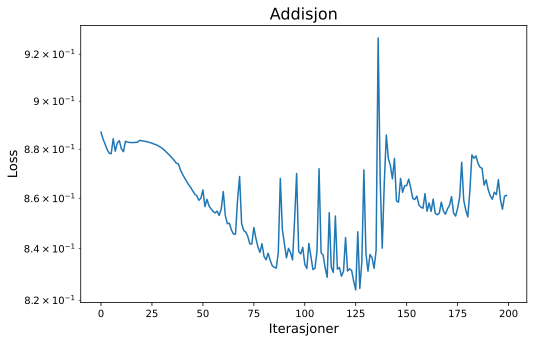

In [197]:
n = 200

test_model_add = make_model(r=6, d=30, m=10, L=3, p=40, k=20)
addition_data = get_train_test_addition(n_digit=2, samples_per_batch=250, n_batches_train=20, n_batches_test=20)

trained_model_add, mean_loss_arr_add = training_addition(test_model_add, CrossEntropy(), Adam(3e-4), addition_data, 10, n_epochs=n)

iter = np.arange(n)

plt.figure(figsize=(8,5))
plt.title('Addisjon', fontsize = 16)
plt.xlabel('Iterasjoner', fontsize = 13)
plt.ylabel('Loss', fontsize = 13)
plt.semilogy(iter, mean_loss_arr_add)
plt.show()

In [198]:
accuracy_addition = test_addition(trained_model_add, addition_data, m=10)
print(f'Prosentandel riktige for addisjon: {np.round(accuracy_addition, 1)}%')

Prosentandel riktige for addisjon: 29.1%


I treningen av addisjonsproblemet får vi et nokså høyt loss, og ikke veldig bra prosentvis andel treff. Det er forventet at vi skal få høyere loss siden addisjon er et vanskeligere problem enn sortering, men vi trodde at det skulle være mulig å oppnå bedre resultater. Vi har gått nøye gjennom og debugget store deler av modellen vår og treningen. I tillegg har vi inmplementert enda flere tester i test_grad.ipynb, men disse viser at koden fungerer som forventet. Vi antar derfor at vi har en liten feil et sted i koden, men siden modellen består av mange elementer er det vanskelig å finne den.

##### Litteraturliste

- Anaconda, Inc. and others. *Performance tips*. Numba. Hentet fra https://numba.pydata.org/numba-doc/latest/user/performance-tips.html
- Anaconda, Inc. and others. *Compiling Python classes with @jitclass*. Numba. Hentet fra https://numba.pydata.org/numba-doc/latest/user/jitclass.html
- *What Is the Necessity of Bias in Neural Networks?*. Turing. Hentet fra https://www.turing.com/kb/necessity-of-bias-in-neural-networks#what-is-bias-in-a-neural-network?
- Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Lukasz Kaiser, and Illia Polosukhin (2017). *Attention is all you need*. Hentet fra https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf 